In [18]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Lambda, Dense, Input, Activation, Dropout, BatchNormalization
from keras.regularizers import l2, l1
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import keras as keras
import seaborn as sns
import argparse

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)


import os, sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

In [2]:
# *** 1. Import data and check stuff
testingFraction = 0.3

In [3]:
# ** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

Dihiggs file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_500kEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv
QCD file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_2MEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv


In [19]:
# ** B. Make testing and training samples
variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'jet2_eta', 'jet3_eta', 
             'nJets', 'jet3_pz', 'jet4_eta', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'scalarHT', 'deltaPhi(h1, h2)', 
             'deltaPhi(h1 jets)', 'jet4_pt', 'jet2_pt', 'jet1_pz', 'jet1_pt', 'jet1_mass']

#variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'jet2_eta', 'jet3_eta', 
#             'nJets', 'jet3_pz', 'jet4_eta', 'h1_mass']
data_train, data_test, labels_train, labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, 
                                                                                         variables, testingFraction)

#data_hh_train, data_hh_test, labels_hh_train, labels_hh_test = makeTestTrainSamplesWithUserVariables(hh_raw[hh_raw.isSignal==1], 
#                                                                             qcd_raw[qcd_raw.isSignal==1], 
#                                                                             variables, testingFraction)

# ** C. Apply normalization to make 0mean/1sigma data inputs
#sc = StandardScaler()
sc = MinMaxScaler()
data_train__norm = sc.fit_transform(data_train)
data_test__norm = sc.fit_transform(data_test)


# ** D. Split into qcd (training) and hh ("anomaly")
# add labels
data_train__norm = np.concatenate((data_train__norm, labels_train), 1)
data_test__norm  = np.concatenate((data_test__norm, labels_test), 1)

# make qcd training set and separated testing sets
data_train__norm    = data_train__norm[data_train__norm[:,-1]==0] # training with qcd only
data_hh_test__norm  = data_test__norm[data_test__norm[:,-1]==1] # testing with dihiggs only
data_qcd_test__norm = data_test__norm[data_test__norm[:,-1]==0] # testing with qcd only

# drop 'isSignal' from sets
data_train__norm    = np.delete(data_train__norm, -1, 1)
data_test__norm     = np.delete(data_test__norm, -1, 1)
data_qcd_test__norm = np.delete(data_qcd_test__norm, -1, 1)
data_hh_test__norm  = np.delete(data_hh_test__norm, -1, 1)

#print(len(data_train__norm[0]), len(data_qcd_test__norm[0]), len(data_hh_test__norm[0]), len(data_train.columns))

N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [20]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



In [38]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean_hh.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim(-2e-3, 2e-3)
    plt.ylim(-2e-3, 2e-3)
    plt.savefig(filename)
    plt.show()

    """
    filename = os.path.join(model_name, "digits_over_latent_hh.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()
    """

In [22]:
# network parameters
original_dim = len(data_train__norm[0])
input_shape = (original_dim,)
intermediate_dim = 256
batch_size = 64
latent_dim = 2
epochs = 50

In [23]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 21)           0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 256)          5632        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_7[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_7[0][0]                    
____________________________________________________________________________________________

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 21)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 6660      
_________________________________________________________________
decoder (Model)              (None, 21)                6165      
Total params: 12,825
Trainable params: 12,825
Non-trainable params: 0
_________________________________________________________________


/home/btannenw/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


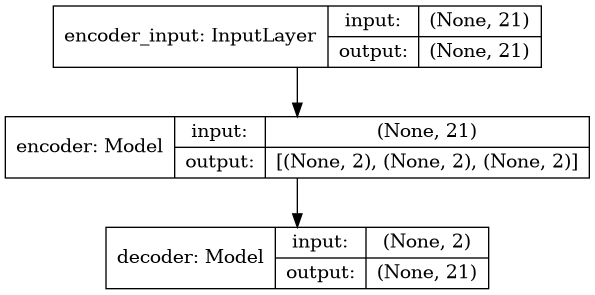

In [34]:
models = (encoder, decoder)
data = (data_test__norm, labels_test['isSignal'].values)

# VAE loss = mse_loss or xent_loss + kl_loss
use_mse=True
if use_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
           to_file='vae_mlp_hh.png',
           show_shapes=True)

In [25]:
hist = vae.fit(data_train__norm,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_test__norm, None))
vae.save_weights('vae1_mlp_hh.h5')

Train on 81597 samples, validate on 58608 samples
Epoch 1/50
81597/81597 [==============================] - 12s 146us/step - loss: 0.6631 - val_loss: 0.6115
Epoch 2/50
81597/81597 [==============================] - 12s 145us/step - loss: 0.6116 - val_loss: 0.6099
Epoch 3/50
81597/81597 [==============================] - 11s 135us/step - loss: 0.6114 - val_loss: 0.6110
Epoch 4/50
81597/81597 [==============================] - 11s 129us/step - loss: 0.6112 - val_loss: 0.6138
Epoch 5/50
81597/81597 [==============================] - 10s 127us/step - loss: 0.6111 - val_loss: 0.6119
Epoch 6/50
81597/81597 [==============================] - 11s 132us/step - loss: 0.6108 - val_loss: 0.6088
Epoch 7/50
81597/81597 [==============================] - 11s 134us/step - loss: 0.6109 - val_loss: 0.6086
Epoch 8/50
81597/81597 [==============================] - 10s 125us/step - loss: 0.6107 - val_loss: 0.6139
Epoch 9/50
81597/81597 [==============================] - 10s 126us/step - loss: 0.6107 - val_

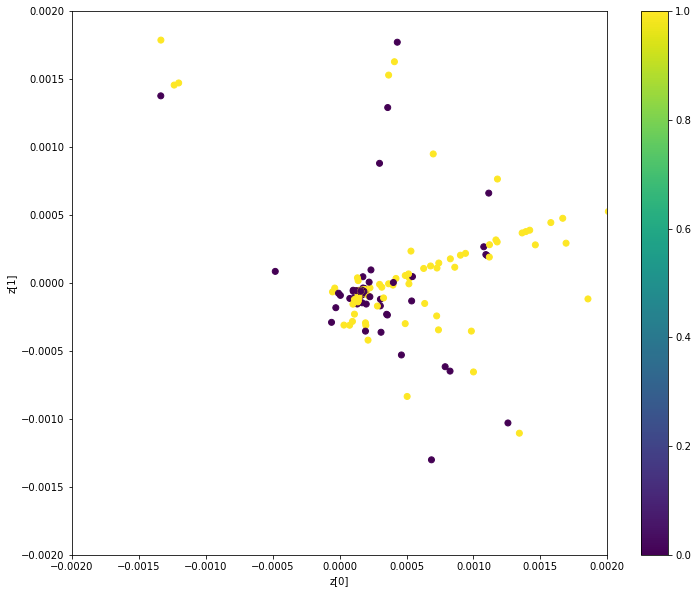

In [39]:
plot_results(models,
            data,
            batch_size=batch_size,
            model_name="vae_mlp_hh")

In [33]:
labels_test['isSignal'].values

array([1, 1, 0, ..., 0, 1, 0])